In [53]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import (
    Input,
    Flatten,
    Dense,
    Dropout,
    GlobalAveragePooling2D,
)
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_curve,
    precision_recall_curve,
)
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image, ImageChops, ImageEnhance

In [54]:
def gaussian_blur_difference(image):
    """Apply Gaussian blur and compute absolute difference."""
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    diff = cv2.absdiff(gray, blurred)
    return cv2.cvtColor(diff, cv2.COLOR_GRAY2BGR)


def error_level_analysis(image, quality=95):
    """Perform Error Level Analysis (ELA) on an image."""
    try:
        im = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        temp_compressed = "temp_compressed.jpg"
        im.save(temp_compressed, "JPEG", quality=quality)
        compressed = Image.open(temp_compressed)
        ela_image = ImageChops.difference(im, compressed)
        ela_image = ImageEnhance.Brightness(ela_image).enhance(5)
        os.remove(temp_compressed)
        return cv2.cvtColor(np.array(ela_image), cv2.COLOR_RGB2BGR)
    except Exception as e:
        print(f"ELA Error: {e}")
        return None


def preprocess_image(image, image_size=(224, 224)):
    """Apply Gaussian Blur Difference and Error Level Analysis."""
    gb_diff = gaussian_blur_difference(image)
    ela_image = error_level_analysis(image)
    if ela_image is None:
        return None
    gb_resized = cv2.resize(gb_diff, image_size)
    ela_resized = cv2.resize(ela_image, image_size)
    return cv2.addWeighted(gb_resized, 0.2, ela_resized, 0.8, 0)

In [55]:
def prepare_dataset(dataset_path, image_size=(224, 224), data_limit=None):
    """Load and preprocess images, returning feature matrix X and labels y."""
    X, y = [], []
    for class_name in ["Au", "Tp"]:
        class_path = os.path.join(dataset_path, class_name)
        label = 0 if class_name == "Au" else 1
        data_list = (
            os.listdir(class_path)[0:data_limit]
            if data_limit
            else os.listdir(class_path)
        )
        for img_file in data_list:
            if img_file.lower().endswith(
                (".png", ".jpg", ".jpeg", ".tif", ".tiff", ".bmp")
            ):
                img = cv2.imread(os.path.join(class_path, img_file))
                processed_img = preprocess_image(img, image_size)
                if processed_img is not None:
                    X.append(processed_img)
                    y.append(label)
                    output_path = os.path.join(
                        dataset_path, "preprocessed_images", class_name, img_file
                    )
                    cv2.imwrite(output_path, processed_img)

    return np.array(X), np.array(y)

In [56]:
import tensorflow as tf
from tensorflow.keras.layers import (
    Input,
    Dense,
    Dropout,
    GlobalAveragePooling2D,
    GlobalMaxPooling2D,
    Reshape,
    Add,
    Multiply,
    Activation,
    Lambda,
    Concatenate,
    Conv2D
)
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

def cbam_module(inputs, reduction_ratio=8):

    channel = inputs.shape[-1]

    shared_mlp_one = Dense(channel // reduction_ratio, activation='relu', kernel_initializer='he_normal', use_bias=True, bias_initializer='zeros')
    shared_mlp_two = Dense(channel, kernel_initializer='he_normal', use_bias=True, bias_initializer='zeros')

    avg_pool = GlobalAveragePooling2D()(inputs)
    avg_pool = Reshape((1, 1, channel))(avg_pool)
    avg_pool_out = shared_mlp_two(shared_mlp_one(avg_pool))

    max_pool = GlobalMaxPooling2D()(inputs)
    max_pool = Reshape((1, 1, channel))(max_pool)
    max_pool_out = shared_mlp_two(shared_mlp_one(max_pool))

    channel_attention = Activation('sigmoid')(Add()([avg_pool_out, max_pool_out]))

    channel_refined_feature = Multiply()([inputs, channel_attention])

    avg_pool_spatial = Lambda(lambda x: tf.reduce_mean(x, axis=3, keepdims=True))(channel_refined_feature)
    max_pool_spatial = Lambda(lambda x: tf.reduce_max(x, axis=3, keepdims=True))(channel_refined_feature)
    
    concat_spatial = Concatenate(axis=3)([avg_pool_spatial, max_pool_spatial])

    spatial_attention = Conv2D(1, kernel_size=(7, 7), strides=1, padding='same', activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(concat_spatial)

    refined_feature = Multiply()([channel_refined_feature, spatial_attention])

    return refined_feature

def build_model_with_fine_tuning(input_shape=(224, 224, 3), fine_tune_at=30):
    base_model = MobileNetV2(input_shape=input_shape,
                             include_top=False,
                             weights='imagenet')

    base_model.trainable = True
    
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False
        
    print(f"Total layers in base_model: {len(base_model.layers)}")
    print(f"Number of trainable layers: {len(base_model.trainable_variables)}")

    inputs = Input(shape=input_shape)
   
    x = base_model(inputs, training=False)

    x = cbam_module(x)

    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.2)(x)

    x = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
    x = Dropout(0.5)(x) 

    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs, outputs)
    model.compile(
        optimizer=Adam(learning_rate=2e-4), 
        loss="binary_crossentropy",
        metrics=["accuracy", tf.keras.metrics.AUC(name='auc'), tf.keras.metrics.Recall(name='recall')]
    )

    return model

In [57]:
def train_model(model, X, y, epochs=80):
    """Train the model with optimized parameters and class weighting."""
    X = tf.keras.applications.mobilenet_v2.preprocess_input(X)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )
    print(X_train.shape, y_train.shape)

    X_test, X_val, y_test, y_val = train_test_split(
        X_test, y_test, test_size=0.5, stratify=y_test, random_state=42
    )
    print(X_test.shape, y_test.shape)
    print(X_val.shape, y_val.shape)
    early_stopping = EarlyStopping(
        monitor="val_loss", patience=5, restore_best_weights=True
    )
    # lr_scheduler = ReduceLROnPlateau(
    #     monitor="val_loss", factor=0.2, patience=10, min_lr=1e-7
    # )

    history = model.fit(
        X_train,
        y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        callbacks=[early_stopping],  
        
    )
    return model, history, X_test, y_test

In [70]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_curve,
    precision_recall_curve,
)

def evaluate_model(model, X_test, y_test):
    """Evaluate the model on the test set and generate various plots."""
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
    y_pred_proba = model.predict(X_test)
    y_pred = (y_pred_proba > 0.5).astype(int).flatten()

    print("\nTest Metrics:")
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=["Non-Forged", "Forged"],
        yticklabels=["Non-Forged", "Forged"],
    )
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.figure()
    plt.plot(fpr, tpr, label=f"ROC curve (AUC)")
    plt.plot([0, 1], [0, 1], "k--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    plt.figure()
    plt.plot(recall, precision, label="Precision-Recall Curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend()
    plt.show()

    thresholds = _  # thresholds from precision_recall_curve
    recall_for_thresholds = recall[:-1]  # exclude last recall to align with thresholds

    plt.figure()
    plt.plot(thresholds, recall_for_thresholds, label="Recall vs Threshold", color="green")
    plt.xlabel("Threshold")
    plt.ylabel("Recall")
    plt.title("Recall vs Threshold Curve")
    plt.legend()
    plt.show()


In [59]:
# Step 1: Build model
image_size = (224, 224,3)
model = build_model_with_fine_tuning(image_size)
model.summary()

Total layers in base_model: 154
Number of trainable layers: 126


Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mobilenetv2_1.00_2… │ (None, 7, 7,      │  2,257,984 │ input_layer_6[0]… │
│ (Functional)        │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1280)      │          0 │ mobilenetv2_1.00… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 1280)      │          0 │ mobilenetv2_1.00… │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_4 (Reshape) │ (None, 1, 1,      │          0 │ global_average_p… │
│                     │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_5 (Reshape) │ (None, 1, 1,      │          0 │ global_max_pooli… │
│                     │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 1, 1, 160) │    204,960 │ reshape_4[0][0],  │
│                     │                   │            │ reshape_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 1, 1,      │    206,080 │ dense_8[0][0],    │
│                     │ 1280)             │            │ dense_8[1][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 1, 1,      │          0 │ dense_9[0][0],    │
│                     │ 1280)             │            │ dense_9[1][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 1, 1,      │          0 │ add_2[0][0]       │
│ (Activation)        │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_4          │ (None, 7, 7,      │          0 │ mobilenetv2_1.00… │
│ (Multiply)          │ 1280)             │            │ activation_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_4 (Lambda)   │ (None, 7, 7, 1)   │          0 │ multiply_4[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_5 (Lambda)   │ (None, 7, 7, 1)   │          0 │ multiply_4[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 7, 7, 2)   │          0 │ lambda_4[0][0],   │
│ (Concatenate)       │                   │            │ lambda_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 7, 7, 1)   │         98 │ concatenate_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_5          │ (None, 7, 7,      │          0 │ multiply_4[0][0], │
│ (Multiply)          │ 1280)             │            │ conv2d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1280)      │          0 │ multiply_5[0][0]  │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 1280)      │          0 │ global_average_p

 Total params: 2,833,219 (10.81 MB)

 Trainable params: 2,779,571 (10.60 MB)

 Non-trainable params: 53,648 (209.56 KB)

In [60]:
image_size = (224, 224)
# Step 2: Define dataset path and image size
dataset_path = r"../CASIA22"

# Step 3: Prepare dataset
X, y = prepare_dataset(dataset_path, image_size)

In [61]:
model, history, X_test, y_test = train_model(model, X, y, epochs=20)


(10091, 224, 224, 3) (10091,)
(1261, 224, 224, 3) (1261,)
(1262, 224, 224, 3) (1262,)
Epoch 1/20
316/316 ━━━━━━━━━━━━━━━━━━━━ 415s 1s/step - accuracy: 0.8334 - auc: 0.8987 - loss: 0.5869 - recall: 0.7840 - val_accuracy: 0.6323 - val_auc: 0.5985 - val_loss: 5.2000 - val_recall: 0.1072
Epoch 2/20
316/316 ━━━━━━━━━━━━━━━━━━━━ 391s 1s/step - accuracy: 0.9288 - auc: 0.9812 - loss: 0.3297 - recall: 0.9505 - val_accuracy: 0.6323 - val_auc: 0.7146 - val_loss: 2.9299 - val_recall: 0.1033
Epoch 3/20
316/316 ━━━━━━━━━━━━━━━━━━━━ 391s 1s/step - accuracy: 0.9414 - auc: 0.9883 - loss: 0.2586 - recall: 0.9515 - val_accuracy: 0.6181 - val_auc: 0.8489 - val_loss: 1.6159 - val_recall: 0.0604
Epoch 4/20
316/316 ━━━━━━━━━━━━━━━━━━━━ 391s 1s/step - accuracy: 0.9440 - auc: 0.9882 - loss: 0.2347 - recall: 0.9487 - val_accuracy: 0.6767 - val_auc: 0.8364 - val_loss: 1.6291 - val_recall: 0.2086
Epoch 5/20
316/316 ━━━━━━━━━━━━━━━━━━━━ 394s 1s/step - accuracy: 0.9593 - auc: 0.9938 - loss: 0.1777 - recall: 0.9642 

In [71]:
evaluate_model(model, X_test, y_test)

40/40 ━━━━━━━━━━━━━━━━━━━━ 16s 399ms/step - accuracy: 0.8685 - auc: 0.9430 - loss: 0.4948 - recall: 0.7724


ValueError: too many values to unpack (expected 2)

In [40]:
model.save("../exported/ifd_mobilenet_attention_june28.keras")

dict_keys(['accuracy', 'auc', 'loss', 'recall', 'val_accuracy', 'val_auc', 'val_loss', 'val_recall'])


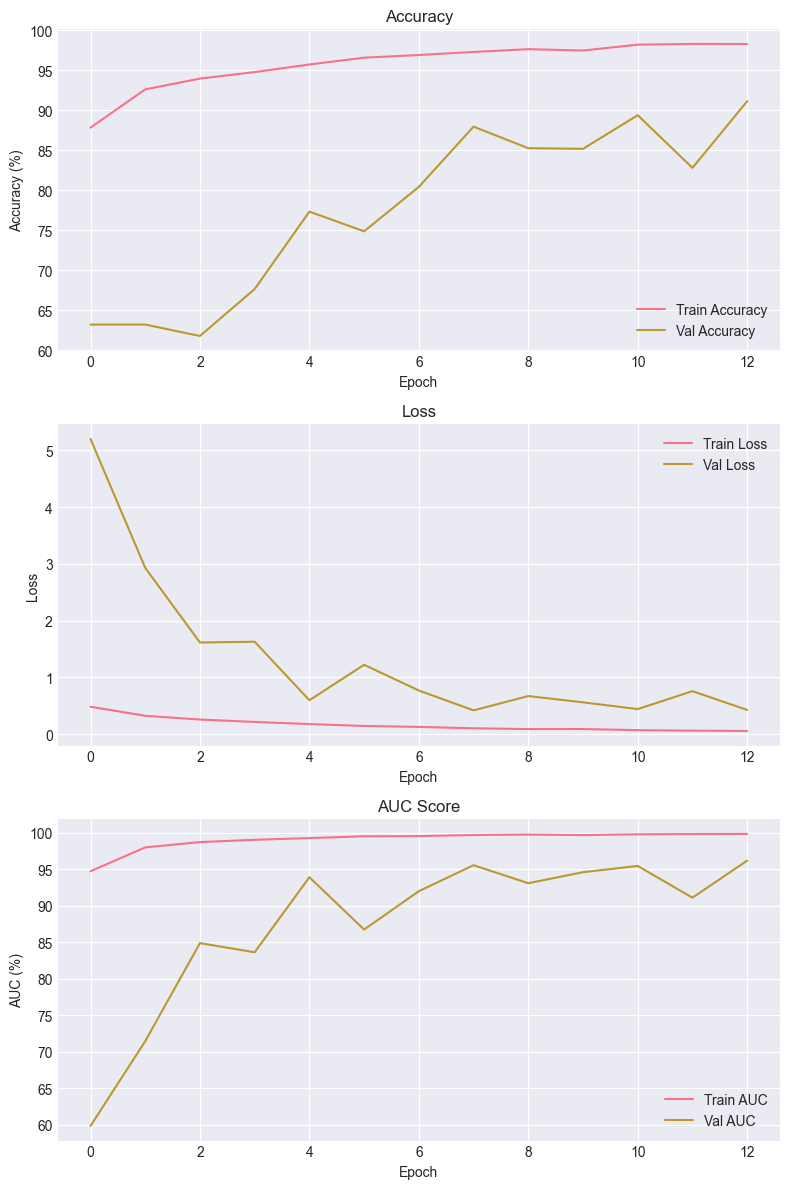

In [63]:
def plot_training_curves(history):
    """Plot training history including loss, accuracy, and AUC on a 0-100% scale."""
    print(history.history.keys())

    fig, ax = plt.subplots(3, 1, figsize=(8, 12))  # 3 rows, 1 column, taller figure

    # Accuracy (Scaled to 0-100%)
    ax[0].plot(np.array(history.history["accuracy"]) * 100, label="Train Accuracy")
    ax[0].plot(np.array(history.history["val_accuracy"]) * 100, label="Val Accuracy")
    ax[0].set_title("Accuracy")
    ax[0].set_ylabel("Accuracy (%)")
    ax[0].set_xlabel("Epoch")
    # ax[0].set_ylim(70, 110)
    ax[0].legend()

    # Loss (Keep original scale)
    ax[1].plot(np.array(history.history["loss"]), label="Train Loss")
    ax[1].plot(np.array(history.history["val_loss"]), label="Val Loss")
    ax[1].set_title("Loss")
    ax[1].set_ylabel("Loss")
    ax[1].set_xlabel("Epoch")
    # ax[1].set_ylim(0, 30)
    ax[1].legend()

    # AUC (Scaled to 0-100%)
    ax[2].plot(np.array(history.history["auc"]) * 100, label="Train AUC")
    ax[2].plot(np.array(history.history["val_auc"]) * 100, label="Val AUC")
    ax[2].set_title("AUC Score")
    ax[2].set_ylabel("AUC (%)")
    ax[2].set_xlabel("Epoch")
    # ax[2].set_ylim(80, 110)
    ax[2].legend()

    plt.tight_layout()  # Adjust layout for better spacing
    plt.show()


# Step 6: Plot training curves
plot_training_curves(history)

In [64]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.patches import Rectangle

# Set style for better-looking plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

def plot_training_curves(history, save_plot=False, figsize=(15, 10)):
    """
    Enhanced training history plotting with better visualization and analysis.
    
    Args:
        history: Keras training history object
        save_plot: Whether to save the plot as an image
        figsize: Figure size tuple
    """
    
    print("📊 Available metrics:", list(history.history.keys()))
    
    # Create figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=figsize)
    fig.suptitle('Training History Analysis', fontsize=16, fontweight='bold', y=0.98)
    
    # Get epochs
    epochs = range(1, len(history.history['accuracy']) + 1)
    
    # Extract data
    train_acc = np.array(history.history['accuracy'])
    val_acc = np.array(history.history['val_accuracy'])
    train_loss = np.array(history.history['loss'])
    val_loss = np.array(history.history['val_loss'])
    
    # Plot 1: Accuracy with enhanced styling
    axes[0, 0].plot(epochs, train_acc * 100, 'o-', linewidth=3, markersize=6, 
                   color='#2E86AB', label='Training Accuracy', alpha=0.8)
    axes[0, 0].plot(epochs, val_acc * 100, 's-', linewidth=3, markersize=6, 
                   color='#F24236', label='Validation Accuracy', alpha=0.8)
    
    # Add best validation accuracy point
    best_val_epoch = np.argmax(val_acc) + 1
    best_val_acc = np.max(val_acc) * 100
    axes[0, 0].plot(best_val_epoch, best_val_acc, 'g*', markersize=15, 
                   label=f'Best Val Acc: {best_val_acc:.2f}%')
    
    axes[0, 0].set_title('Model Accuracy Over Time', fontweight='bold', fontsize=12)
    axes[0, 0].set_ylabel('Accuracy (%)', fontweight='bold')
    axes[0, 0].set_xlabel('Epoch', fontweight='bold')
    axes[0, 0].legend(loc='lower right')
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].set_ylim(0, 100)
    
    # Add accuracy gap annotation
    final_train_acc = train_acc[-1] * 100
    final_val_acc = val_acc[-1] * 100
    acc_gap = final_train_acc - final_val_acc
    axes[0, 0].text(0.02, 0.98, f'Final Gap: {acc_gap:.1f}%', 
                   transform=axes[0, 0].transAxes, fontsize=10, 
                   bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7),
                   verticalalignment='top')
    
    # Plot 2: Loss with enhanced styling
    axes[0, 1].plot(epochs, train_loss, 'o-', linewidth=3, markersize=6, 
                   color='#2E86AB', label='Training Loss', alpha=0.8)
    axes[0, 1].plot(epochs, val_loss, 's-', linewidth=3, markersize=6, 
                   color='#F24236', label='Validation Loss', alpha=0.8)
    
    # Add best validation loss point
    best_val_loss_epoch = np.argmin(val_loss) + 1
    best_val_loss = np.min(val_loss)
    axes[0, 1].plot(best_val_loss_epoch, best_val_loss, 'g*', markersize=15, 
                   label=f'Best Val Loss: {best_val_loss:.3f}')
    
    axes[0, 1].set_title('Model Loss Over Time', fontweight='bold', fontsize=12)
    axes[0, 1].set_ylabel('Loss', fontweight='bold')
    axes[0, 1].set_xlabel('Epoch', fontweight='bold')
    axes[0, 1].legend(loc='upper right')
    axes[0, 1].grid(True, alpha=0.3)
    
    # Plot 3: Training Analysis - Overfitting Detection
    axes[1, 0].fill_between(epochs, train_acc * 100, val_acc * 100, 
                           where=(train_acc >= val_acc), color='red', alpha=0.3, 
                           label='Potential Overfitting', interpolate=True)
    axes[1, 0].fill_between(epochs, train_acc * 100, val_acc * 100, 
                           where=(train_acc < val_acc), color='green', alpha=0.3, 
                           label='Good Generalization', interpolate=True)
    
    axes[1, 0].plot(epochs, train_acc * 100, 'b-', linewidth=2, alpha=0.7)
    axes[1, 0].plot(epochs, val_acc * 100, 'r-', linewidth=2, alpha=0.7)
    
    axes[1, 0].set_title('Overfitting Analysis', fontweight='bold', fontsize=12)
    axes[1, 0].set_ylabel('Accuracy (%)', fontweight='bold')
    axes[1, 0].set_xlabel('Epoch', fontweight='bold')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Plot 4: Learning Rate and Convergence Analysis
    # Calculate learning rate (approximation based on loss change)
    loss_change = np.abs(np.diff(train_loss))
    learning_stability = 1 / (1 + loss_change * 10)  # Stability metric
    
    axes[1, 1].plot(epochs[1:], learning_stability, 'g-', linewidth=3, 
                   label='Learning Stability')
    axes[1, 1].set_title('Learning Stability Over Time', fontweight='bold', fontsize=12)
    axes[1, 1].set_ylabel('Stability Score', fontweight='bold')
    axes[1, 1].set_xlabel('Epoch', fontweight='bold')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    # Add convergence annotation
    if len(epochs) > 10:
        recent_stability = np.mean(learning_stability[-5:])
        if recent_stability > 0.8:
            conv_status = "Converged"
            conv_color = "green"
        elif recent_stability > 0.6:
            conv_status = "Converging"
            conv_color = "orange"
        else:
            conv_status = "Unstable"
            conv_color = "red"
            
        axes[1, 1].text(0.02, 0.98, f'Status: {conv_status}', 
                       transform=axes[1, 1].transAxes, fontsize=10, 
                       bbox=dict(boxstyle="round,pad=0.3", facecolor=conv_color, alpha=0.7),
                       verticalalignment='top')
    
    plt.tight_layout()
    
    # Print analysis summary
    print_training_analysis(train_acc, val_acc, train_loss, val_loss, epochs)
    
    if save_plot:
        plt.savefig('training_curves_analysis.png', dpi=300, bbox_inches='tight')
    
    plt.show()

def print_training_analysis(train_acc, val_acc, train_loss, val_loss, epochs):
    """Print detailed training analysis."""
    
    print("\n" + "="*60)
    print("🔍 TRAINING ANALYSIS SUMMARY")
    print("="*60)
    
    # Final metrics
    final_train_acc = train_acc[-1] * 100
    final_val_acc = val_acc[-1] * 100
    final_train_loss = train_loss[-1]
    final_val_loss = val_loss[-1]
    
    print(f"📈 Final Training Accuracy:   {final_train_acc:.2f}%")
    print(f"📊 Final Validation Accuracy: {final_val_acc:.2f}%")
    print(f"📉 Final Training Loss:       {final_train_loss:.4f}")
    print(f"📋 Final Validation Loss:     {final_val_loss:.4f}")
    
    # Performance gaps
    acc_gap = final_train_acc - final_val_acc
    loss_gap = final_val_loss - final_train_loss
    
    print(f"\n🔍 Performance Gaps:")
    print(f"   Accuracy Gap:  {acc_gap:.2f}%")
    print(f"   Loss Gap:      {loss_gap:.4f}")
    
    # Best performance
    best_val_acc = np.max(val_acc) * 100
    best_val_epoch = np.argmax(val_acc) + 1
    best_val_loss = np.min(val_loss)
    best_loss_epoch = np.argmin(val_loss) + 1
    
    print(f"\n🏆 Best Performance:")
    print(f"   Best Val Accuracy: {best_val_acc:.2f}% (Epoch {best_val_epoch})")
    print(f"   Best Val Loss:     {best_val_loss:.4f} (Epoch {best_loss_epoch})")
    
    # Training diagnosis
    print(f"\n🩺 Training Diagnosis:")
    
    if acc_gap > 15:
        print("   ⚠️  SEVERE OVERFITTING DETECTED")
        print("   💡 Suggestions: Reduce model complexity, add regularization, early stopping")
    elif acc_gap > 8:
        print("   ⚠️  MODERATE OVERFITTING")
        print("   💡 Suggestions: Add dropout, reduce learning rate, data augmentation")
    elif acc_gap > 3:
        print("   ✅ SLIGHT OVERFITTING (Normal)")
        print("   💡 Model is learning well with minor overfitting")
    else:
        print("   ✅ GOOD GENERALIZATION")
        print("   💡 Model is generalizing well to validation data")
    
    # Convergence analysis
    recent_epochs = min(5, len(epochs) // 4)
    recent_val_acc_std = np.std(val_acc[-recent_epochs:])
    
    if recent_val_acc_std < 0.01:
        print(f"   📈 CONVERGED: Validation accuracy is stable")
    elif recent_val_acc_std < 0.02:
        print(f"   📈 CONVERGING: Small fluctuations in validation accuracy")
    else:
        print(f"   📈 STILL LEARNING: Validation accuracy still changing")
    
    # Training recommendations
    print(f"\n💡 RECOMMENDATIONS:")
    
    if final_val_acc < 70:
        print("   🔧 Low accuracy: Try different architecture, more data, or feature engineering")
    
    if loss_gap > 0.5:
        print("   🔧 High loss gap: Implement early stopping or reduce model complexity")
    
    if best_val_epoch < len(epochs) * 0.7:
        print("   🔧 Early peak: Consider early stopping or learning rate scheduling")
    
    print("="*60)

def plot_simple_training_curves(history):
    """Simplified version of the original function with enhancements."""
    
    print("Available metrics:", list(history.history.keys()))
    
    fig, ax = plt.subplots(2, 1, figsize=(10, 8))
    
    epochs = range(1, len(history.history['accuracy']) + 1)
    
    # Enhanced Accuracy Plot
    ax[0].plot(epochs, np.array(history.history['accuracy']) * 100, 
               'o-', linewidth=2, markersize=4, label='Training Accuracy', color='blue')
    ax[0].plot(epochs, np.array(history.history['val_accuracy']) * 100, 
               's-', linewidth=2, markersize=4, label='Validation Accuracy', color='red')
    
    ax[0].set_title('Model Accuracy', fontweight='bold', fontsize=14)
    ax[0].set_ylabel('Accuracy (%)', fontweight='bold')
    ax[0].set_xlabel('Epoch', fontweight='bold')
    ax[0].legend()
    ax[0].grid(True, alpha=0.3)
    ax[0].set_ylim(0, 100)
    
    # Enhanced Loss Plot
    ax[1].plot(epochs, np.array(history.history['loss']), 
               'o-', linewidth=2, markersize=4, label='Training Loss', color='blue')
    ax[1].plot(epochs, np.array(history.history['val_loss']), 
               's-', linewidth=2, markersize=4, label='Validation Loss', color='red')
    
    ax[1].set_title('Model Loss', fontweight='bold', fontsize=14)
    ax[1].set_ylabel('Loss', fontweight='bold')
    ax[1].set_xlabel('Epoch', fontweight='bold')
    ax[1].set_ylim(0,2)
    ax[1].legend()
    ax[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Example usage:
# plot_training_curves(history)  # Enhanced version
# plot_simple_training_curves(history)  # Simple enhanced version

/Users/logpoint/Documents/SoftwareProjects/Thesis/venv/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_518']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


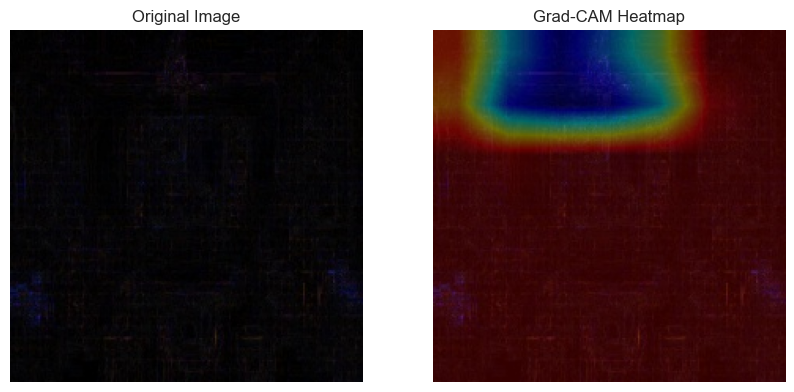

In [65]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2

def make_gradcam_heatmap(img_array, model, last_conv_layer_name='block_16_project'):
    """
    Generate a Grad-CAM heatmap for a model that contains a nested MobileNetV2 submodel.

    Args:
        img_array: Preprocessed input image batch as a numpy array, shape (1, H, W, 3)
        model: Full Keras model containing 'mobilenetv2_1.00_224' as a submodel
        last_conv_layer_name: Name of the last convolutional layer inside the MobileNetV2 submodel

    Returns:
        heatmap: 2D numpy array with normalized heatmap values [0,1]
    """
    # Step 1: Get the MobileNetV2 base model inside your full model
    base_model = model.get_layer('mobilenetv2_1.00_224')

    # Step 2: Create a model that maps the base model inputs to:
    # (a) the output of the conv layer you want
    # (b) the base model output
    # This ensures the graph is consistent and inputs connect to outputs.
    grad_model = tf.keras.models.Model(
        inputs=base_model.inputs,
        outputs=[base_model.get_layer(last_conv_layer_name).output, base_model.output]
    )

    # Step 3: Run forward pass under GradientTape to record operations
    with tf.GradientTape() as tape:
        # Cast to tensor and watch
        inputs = tf.cast(img_array, tf.float32)
        tape.watch(inputs)

        conv_outputs, predictions = grad_model(inputs)
        # Assuming binary classification or single output node, adapt if needed
        loss = predictions[:, 0]

    # Step 4: Compute gradients of the top predicted class w.r.t. conv layer output
    grads = tape.gradient(loss, conv_outputs)

    # Step 5: Global average pooling of gradients over height and width
    pooled_grads = tf.reduce_mean(grads, axis=(1, 2))

    # Step 6: Weight the convolution outputs with pooled gradients
    conv_outputs = conv_outputs[0]          # Remove batch dimension
    pooled_grads = pooled_grads[0]

    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)

    # Step 7: Apply ReLU and normalize to [0,1]
    heatmap = tf.nn.relu(heatmap)
    heatmap = heatmap / (tf.reduce_max(heatmap) + 1e-10)

    return heatmap.numpy()


def display_gradcam(img, heatmap, alpha=0.4, cmap=cv2.COLORMAP_JET):
    """
    Overlay the Grad-CAM heatmap on the original image and display both.

    Args:
        img: Original image as numpy array (H, W, 3) in uint8 format
        heatmap: 2D numpy array of Grad-CAM heatmap normalized [0,1]
        alpha: Float, heatmap intensity overlay factor
        cmap: OpenCV colormap to colorize heatmap
    """
    # Resize heatmap to original image size
    heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap_resized = np.uint8(255 * heatmap_resized)

    # Apply color map
    heatmap_color = cv2.applyColorMap(heatmap_resized, cmap)

    # Superimpose heatmap onto original image
    superimposed_img = heatmap_color * alpha + img
    superimposed_img = np.clip(superimposed_img, 0, 255).astype(np.uint8)

    # Plot original and Grad-CAM images side-by-side
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(superimposed_img)
    plt.title('Grad-CAM Heatmap')
    plt.axis('off')
    plt.show()


# Example usage:
# Assuming `model` is your full model,
# and `img` is a preprocessed input image in [-1,1] range expected by MobileNetV2.

# Reverse preprocessing to uint8 for display

import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

img_path = "../CASIA22/preprocessed_images/Tp/Tp_D_CRN_S_N_sec00071_art00028_11281.jpg"
# img_path = "../CASIA22/preprocessed_images/Tp/Tp_D_NRN_S_B_nat00023_cha00024_20076.jpg"
# img_paht = "../CASIA22/preprocessed_images/Tp/Tp_S_NRN_S_O_cha00077_cha00077_11017.jpg"

# Step 1: Load image from disk
img = cv2.imread(img_path)
if img is None:
    raise ValueError("Image not found or cannot be read.")

# Step 2: Resize if needed (MobileNetV2 expects 224x224)
img = cv2.resize(img, (224, 224))

# Step 3: Keep a copy for visualization (convert BGR to RGB for matplotlib)
original_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Step 4: Preprocess for MobileNetV2
img = preprocess_input(img.astype(np.float32))  # Converts to range [-1, 1]

# Step 5: Expand dims for batch size = 1
img_array = np.expand_dims(img, axis=0)

# Step 6: Generate heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name='block_16_project')

# Step 7: Display
display_gradcam(original_img, heatmap)



Available metrics: ['accuracy', 'auc', 'loss', 'recall', 'val_accuracy', 'val_auc', 'val_loss', 'val_recall']


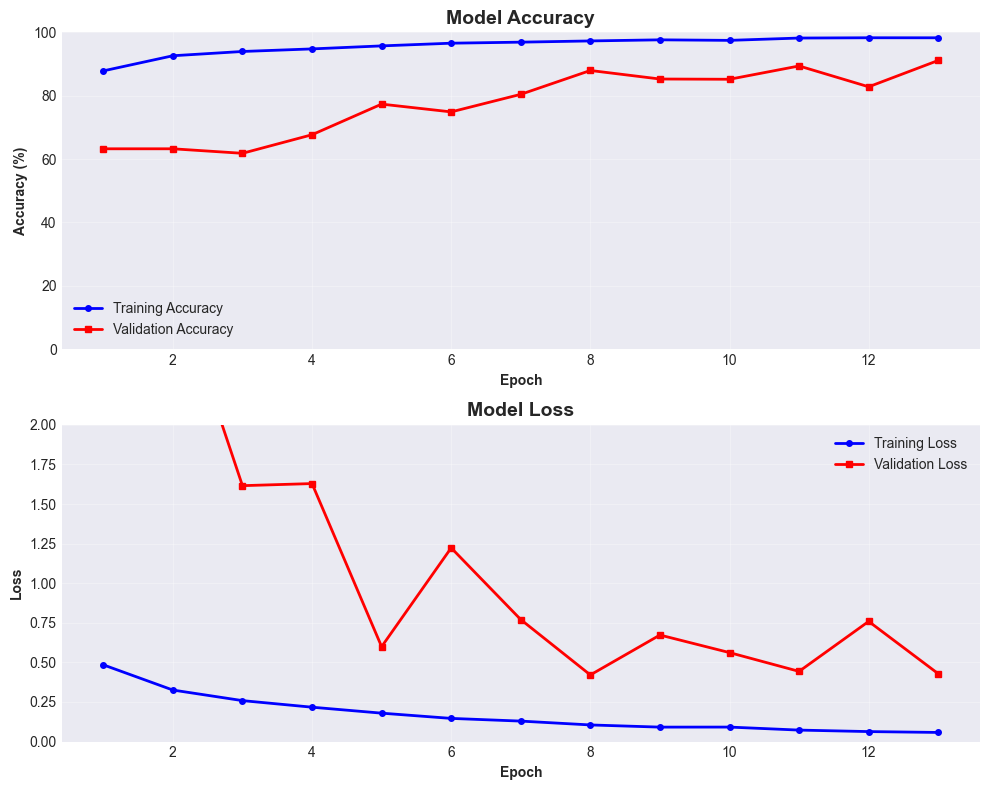

In [66]:
plot_simple_training_curves(history)

In [67]:
import matplotlib.pyplot as plt

def plot_recall_vs_epochs(history):
    train_recall = history.history['recall']
    val_recall = history.history.get('val_recall')  # Optional if you used validation_data

    plt.figure()
    plt.plot(train_recall, label="Train Recall")
    if val_recall:
        plt.plot(val_recall, label="Validation Recall")
    plt.xlabel("Epochs")
    plt.ylabel("Recall")
    plt.title("Recall vs Epochs")
    plt.legend()
    plt.grid(True)
    plt.show()


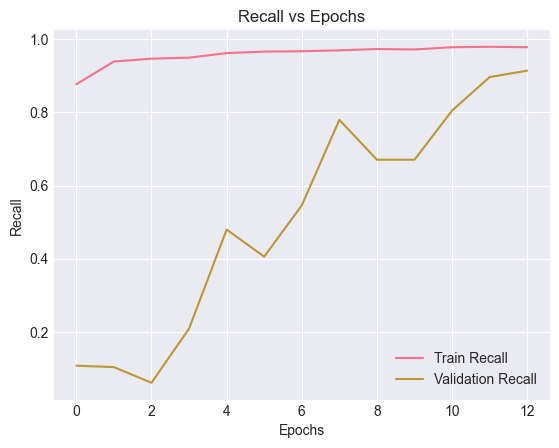

In [68]:
plot_recall_vs_epochs(history)
